
This notebook uses the output of the rule
--- 75_assm_stats.smk::collect_all_kmer_differences
as input, and produces a distance matrix plot.

Execution directory:  /home/ebertp/work/code/marschall-lab/project-male-assembly/notebooks/plotting/kmers
Working directory:  /home/ebertp/work/projects/sig_chry/paper
Output directory:  /home/ebertp/work/projects/sig_chry/paper/output/figures
Dumping plots to /home/ebertp/work/projects/sig_chry/paper/output/figures


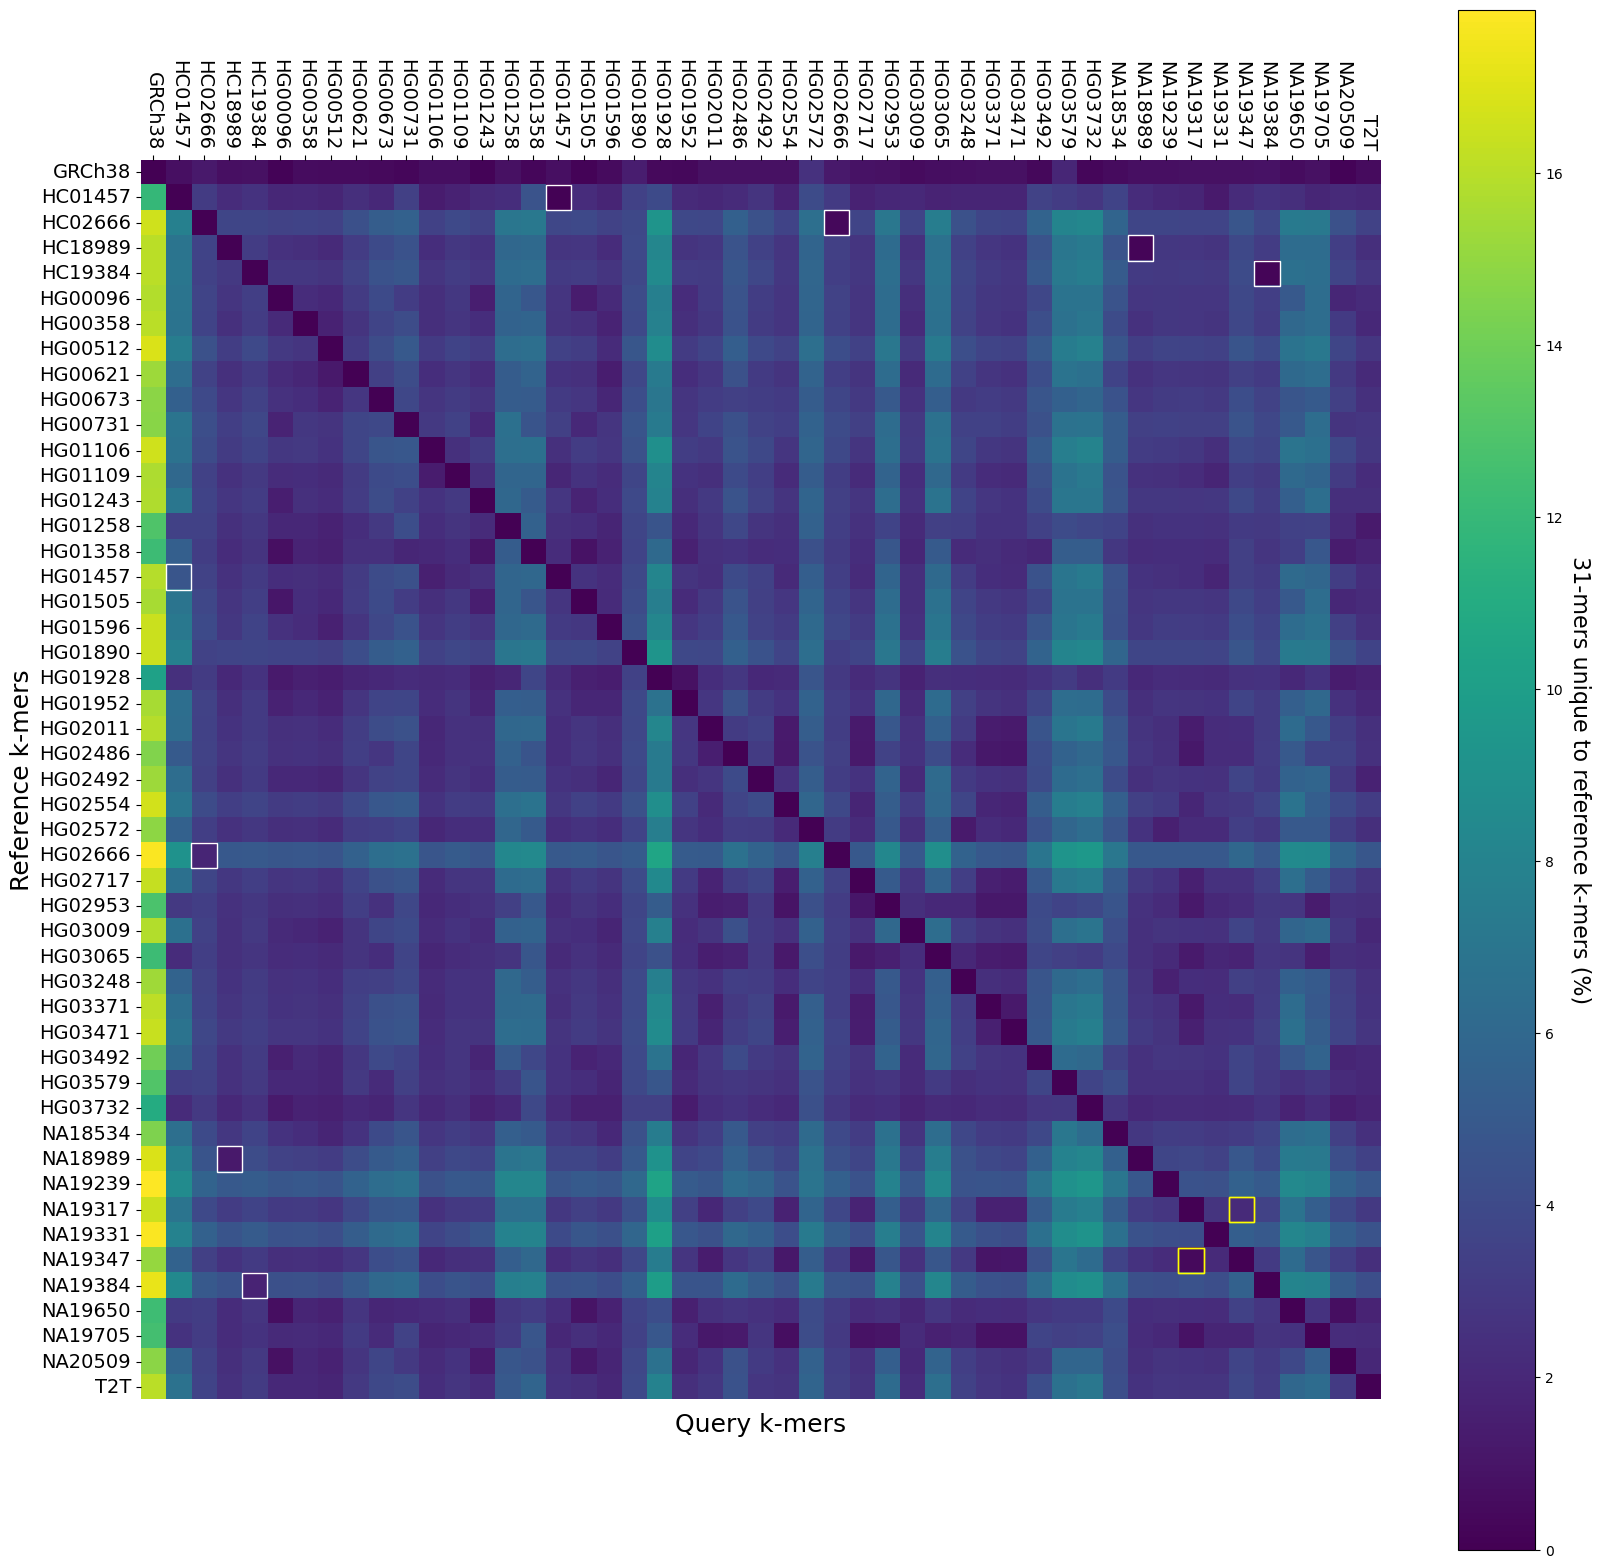

In [3]:
import pathlib as pl
import pandas as pd
import numpy as np
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patch

# required to have text output as "text fields"
# and not individual objects
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

desc="""
This notebook uses the output of the rule
--- 75_assm_stats.smk::collect_all_kmer_differences
as input, and produces a distance matrix plot.
"""

print(desc)

save_plots = True

def find_repo_base(start_path):
    check_path = start_path
    while 1:
        if check_path.name == "project-male-assembly":
            return check_path
        check_path = check_path.parent
    return

exec_dir = pl.Path('.').resolve(strict=True)
paths_json = exec_dir.parent.joinpath("plotting_paths.json").resolve(strict=True)
plotting_paths = json.load(open(paths_json))

repo_dir = find_repo_base(exec_dir)
wd_dir = pl.Path(plotting_paths["wd_dir"]).resolve(strict=True)
out_dir = pl.Path(plotting_paths["fig_out"]).resolve(strict=True)
print('Execution directory: ', exec_dir)
print('Working directory: ', wd_dir)
print('Output directory: ', out_dir)
print('=================================')

diff_file = wd_dir.joinpath("data", "kmer_stats", "SAMPLES.HIFIRW.ONTUL.na.chrY.k31.diffs.tsv")

diffs = pd.read_csv(diff_file, sep='\t', header=0)
num_columns = diffs.select_dtypes(include=['number'])

drop_samples = ['NA24385', 'HG02666', 'HG01457', 'NA18989', 'NA19384', 'HG03456']
drop_samples = ['NA24385']

drop_targets = diffs['target_sample'].isin(drop_samples)
drop_queries = diffs['query_sample'].isin(drop_samples)

drop_rows = drop_targets | drop_queries
diffs = diffs.loc[~drop_rows, :].copy()
diffs = diffs[['target_sample', 'query_sample', 'kmers_target_only_pct']]
diffs = diffs.pivot(index='target_sample', columns='query_sample', values='kmers_target_only_pct')
diffs.fillna(0., inplace=True)

#diffs.index = [rename_samples.get(i, i) for i in diffs.index.values]
#diffs.columns = [rename_samples.get(c, c) for c in diffs.columns]

def create_diff_heatmap(kmer_diffs):
    fig, ax = plt.subplots(figsize=(20,20))
    fig_name = 'fig_kmer_heatmap'
    heatmap = ax.imshow(kmer_diffs)
    
    # Create colorbar
    cbar = ax.figure.colorbar(heatmap, ax=ax)
    cbar.ax.set_ylabel(
        '31-mers unique to reference k-mers (%)',
        rotation=-90,
        va="bottom",
        fontsize=16
    )

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(kmer_diffs.shape[1]), labels=kmer_diffs.columns)
    ax.set_yticks(np.arange(kmer_diffs.shape[0]), labels=kmer_diffs.index.values)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-90,
             ha="right", va='center',
             rotation_mode="anchor", fontsize=14)
    plt.setp(ax.get_yticklabels(), rotation=0,
             ha="right", va='center',
             rotation_mode="anchor", fontsize=14)

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(kmer_diffs.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(kmer_diffs.shape[0]+1)-.5, minor=True)
    #ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    
    pairs = [
        ('HG01457', 'HC01457', 'white'), ('HC02666', 'HG02666', 'white'),
        ('NA19384', 'HC19384', 'white'), ('NA18989', 'HC18989', 'white'),
        ('NA19347', 'NA19317', 'yellow'), ('NA19317', 'NA19347', 'yellow')
    ]
    
    pos_idx = np.arange(diffs.shape[0], dtype=np.int8)
    pos_col = np.arange(diffs.shape[1], dtype=np.int8)
    for p1, p2, c in pairs:
        y = pos_idx[diffs.index == p1]
        x = pos_col[diffs.columns == p2]
        ax.add_patch(
            patch.Rectangle(
                (x-0.5, y-0.5), 1, 1, fill=False, edgecolor=c, lw=1
            )
        )
        y = pos_idx[diffs.index == p2]
        x = pos_col[diffs.columns == p1]
        ax.add_patch(
            patch.Rectangle(
                (x-0.5, y-0.5), 1, 1, fill=False, edgecolor=c, lw=1
            )
        )
    
    ax.set_ylabel('Reference k-mers', fontsize=18)
    ax.set_xlabel('Query k-mers', fontsize=18)

    if save_plots:
        print(f"Dumping plots to {out_dir}")
        plt.savefig(
            out_dir / pl.Path(f'{fig_name}.png'),
            dpi=150, transparent=False, bbox_inches='tight'
        )
        plt.savefig(
            out_dir / pl.Path(f'{fig_name}.pdf'),
            transparent=False, bbox_inches='tight'
        )

    return heatmap, cbar
    
hm, cb = create_diff_heatmap(diffs)
